# KoGPT 모델 LoRA로 학습하기

- 학습 내용
  - [KoGPT](https://github.com/kakaobrain/kogpt) 파라미터를 직접 Fine-Tuning하는 대신 Low Rank 어댑터만 학습하는 LoRA 기법을 사용합니다.
  - HuggingFace에서 제공하는 [PEFT: Parameter-Efficient Fine-Tuning](https://github.com/huggingface/peft) 라이브러리를 활용합니다.
  - 학습 결과는 15MB 정도 크기의 어댑터 파라미터만 저장해도 재사용 할 수 있습니다.  

  
- 환경 필요사항
  - 학습에는 GPU 메모리가 많이 필요하므로 colab 사용 시 유료 요금제 사용을 권장합니다.
  - 구글 드라이브에 `/GPT_Competition/train.csv`, `/GPT_Competition/test.csv`가 업로드 되어있어야 합니다.
  - 학습 결과를 구글드라이브에 저장하므로 약간의 여유공간이 필요합니다.

In [ ]:
# 구글 드라이브와 연동합니다. 권한 허용이 필요합니다.
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
# 라이브러리를 설치합니다.
%pip install -q transformers datasets accelerate
%pip install -q peft

In [ ]:
import numpy as np
import pandas as pd
import os, gc
from tqdm.auto import tqdm
from datetime import datetime, timezone, timedelta

import torch
from torch.utils.data import DataLoader,Dataset

import datasets
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM 

# HuggingFace peft 라이브러리
from peft import get_peft_model, PeftModel, TaskType, LoraConfig

## 데이터 셋 정의하기
- HuggingFace의 Dataset 클래스를 활용합니다. batch 단위로 전처리하기 편리합니다.
- tokenizer 클래스는 batch 단위로 처리하면 속도가 빠릅니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',
)

In [ ]:
# 테스트 데이터를 HuggingFace Dataset으로 불러옵니다.
data_path = '/content/drive/MyDrive/GPT_Competition/train.csv'
train_df = pd.read_csv(data_path)
train_set = datasets.Dataset.from_pandas(train_df)
del train_df

- [Batch mapping](https://huggingface.co/docs/datasets/about_map_batch) 기능을 활용하여 데이터 셋 전체를 미리 토큰화합니다.
- `{text} 한줄 요약: {summary} [EOS]` 형태로 input을 만듭니다. 문장 끝 토큰 `[EOS]`를 직접 추가합니다.
- input에서 생성하려는 `{summary} [EOS]` 부분만 정답 label로 남기고 나머지는 ignore_index인 -100으로 가립니다.
- [GPTJForCausalLM](https://huggingface.co/docs/transformers/model_doc/gptj#transformers.GPTJForCausalLM) 모델에 input_ids와 labels를 넘겨주면 logits과 loss를 계산해줍니다.
- loss 는 모델이 예측한 logits과 정답 label의 [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)로 계산하며 -100인 부분은 계산에서 제외됩니다.

In [ ]:
def train_batch_preprocess(batch):
    prompt = "{text} 한줄 요약:"
    query_text = [prompt.format(text=text) for text in batch['text']]
    target_text = batch['summary']
    query = tokenizer(query_text)
    target = tokenizer(target_text)

    input_ids = [q + t + [tokenizer.eos_token_id] for q, t in zip(query['input_ids'], target['input_ids'])]
    attention_mask = [q + t + [1] for q, t in zip(query['attention_mask'], target['attention_mask'])]
    labels = [[-100] * len(q) + t + [tokenizer.eos_token_id] for q, t in zip(query['input_ids'], target['input_ids'])]

    # 결과로 돌려주는 값들이 추가됩니다.
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [ ]:
# batch단위로 전처리를 실행합니다.
# 토큰화 이후에 id, text, summary는 필요없으므로 버립니다.
train_set = train_set.map(
    train_batch_preprocess,
    remove_columns = ['id', 'text', 'summary'],
    batched = True,
    batch_size = 1000,
)

In [ ]:
# 결과를 확인합니다.
# (eos_token_id = 1, ignore_index = -100)
print(train_set)
print(len(train_set[0]['input_ids']))
print(train_set[0]['input_ids'])
print(train_set[0]['attention_mask'])
print(train_set[0]['labels'])

- train_set은 각 샘플마다 길이가 다릅니다.
- 길이가 서로 다른 샘플을 하나의 배치로 만들기 위해 collate_fn 함수를 작성합니다.
- GPTJ는 문장의 오른쪽 끝부터 생성하는 autoregressive 모델이므로 오른쪽 끝이 같아야합니다. left padding을 사용합니다.
- attention_mask는 0, labels는 -100으로 padding합니다.

In [ ]:
def left_pad(sequence, value, max_len):
    return [value] * (max_len - len(sequence)) + sequence

def collate_fn(batch, device='cuda'):
    length = max(len(row['input_ids']) for row in batch)
    input_ids = [
        left_pad(row['input_ids'], tokenizer.pad_token_id, length)
        for row in batch
    ]
    attention_mask = [
        left_pad(row['attention_mask'], 0, length)
        for row in batch
    ]
    labels = [
        left_pad(row['input_ids'], -100, length)
        for row in batch
    ]
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long , device=device),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long , device=device),
        'labels': torch.tensor(labels, dtype=torch.long , device=device),
    }

In [ ]:
train_loader = DataLoader(
    train_set, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn,
)

## 모델 불러오기
- base model을 불러온뒤 peft model로 감싸줍니다.

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    'kakaobrain/kogpt', revision = 'KoGPT6B-ryan1.5b-float16',
    torch_dtype = torch.float16,
    device_map = 'auto',
)

config
- TaskType: 앞문장에서 뒷문장을 생성하는 CAUSAL_LM입니다.
- r: LoRA에 사용할 rank입니다.
- lora_alpha: LoRA α 계수입니다. (B @ A * α/r) 형태로 들어가는 scale 계수입니다.
- lora_dropout: A, B 보다 앞에 추가할 Dropout 레이어의 drop 비율입니다.
- target_modules: LoRA를 적용할 모듈입니다. `List[str]` 형태이면 해당 키워드로 끝나는 모듈에, `str` 형태이면 정규식에 해당하는 모듈에 적용됩니다.

In [ ]:
peft_config = LoraConfig(
    task_type = TaskType.CAUSAL_LM,
    r=8, lora_alpha=32, lora_dropout=0.1,
    target_modules = ['q_proj', 'v_proj'],
    # target_modules = r".*(q_proj|v_proj)",
)

In [ ]:
print(peft_config)

In [ ]:
peft_model = get_peft_model(base_model, peft_config)
peft_model.to('cuda')
peft_model.train()

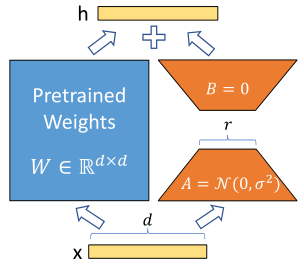

- LoRA peft 모델이 어떤 파라미터를 가지는지 확인해 봅시다.
- lora_A, lora_B 이외에는 freeze인 것이 확인 됩니다.

In [ ]:
pd.DataFrame([
    (param.dtype, param.shape, param.device, param.requires_grad, name)
    for name, param in peft_model.named_parameters()
], columns=['dtype', 'shape', 'device', 'requires_grad', 'name'])

## 학습

- float32, float16이 섞여있으므로 amp autocast를 활용합니다.

In [ ]:
learning_rate = 3e-5

optimizer = torch.optim.Adam(peft_model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def training_step(model, batch, optimizer, scaler):
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        outputs = model(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_mask'],
            labels = batch['labels'],
        )
        step_loss = outputs[0]
    scaler.scale(step_loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return step_loss.detach()

In [ ]:
NUM_EPOCHS = 1

peft_model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    tr_loss = torch.tensor(0.0).to('cuda')
    for batch_idx, batch in enumerate(tqdm(train_loader), start=1):
        step_loss = training_step(peft_model, batch, optimizer, scaler)
        tr_loss += step_loss
        if batch_idx % 100 == 0:
            print("{}. tr_loss: {}".format(batch_idx, tr_loss.item()))
            tr_loss = torch.tensor(0.0).to('cuda')

In [ ]:
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
PEFT_MODEL_PATH = f'/content/drive/MyDrive/GPT_Competition/exp_{TIME_SERIAL}'
peft_model.save_pretrained(PEFT_MODEL_PATH)
print(PEFT_MODEL_PATH)

## 추론
- base 모델을 불러오고, 저장된 PEFT 모델을 불러옵니다.
- 추론 과정은 참고자료2와 동일합니다. 해당 코드를 참고하세요.

In [ ]:
# Install Library
%pip install -q transformers datasets accelerate
%pip install -q peft

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM 
from peft import PeftModel
import os, gc
from datetime import datetime, timezone, timedelta
from tqdm.auto import tqdm

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
# PEFT_MODEL_PATH = "/content/drive/MyDrive/GPT_Competition/exp_??????-??????"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',
)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    'kakaobrain/kogpt', revision = 'KoGPT6B-ryan1.5b-float16',
    torch_dtype = torch.float16,
    device_map = 'auto',
)

In [ ]:
model = PeftModel.from_pretrained(model=base_model, model_id=PEFT_MODEL_PATH)

In [ ]:
class SummaryTestDataset(Dataset):
    def __init__(self, data_path, tokenizer):
        self._data = pd.read_csv(data_path)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        row = self._data.iloc[idx]
        prompt = "{text} 한줄 요약:"
        input_text = prompt.format(text=row['text'])
        input_encoding = self.tokenizer(input_text)

        result = {
            'input_ids': input_encoding['input_ids'],
            'attention_mask': input_encoding['attention_mask'],
        }
        
        return result

    def _left_pad(self, sequence, value, max_len):
        return [value] * (max_len - len(sequence)) + sequence

    def collate_fn(self, batch, device='cuda'):
        input_length = max(len(row['input_ids']) for row in batch)

        input_ids = [
            self._left_pad(row['input_ids'], self.tokenizer.pad_token_id, input_length)
            for row in batch
        ]
        attention_mask = [
            self._left_pad(row['attention_mask'], 0, input_length)
            for row in batch
        ]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long, device=device),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long, device=device),
        }

In [ ]:
test_path = '/content/drive/MyDrive/GPT_Competition/test.csv'
test_set = SummaryTestDataset(test_path, tokenizer)
test_loader = DataLoader(test_set, batch_size=2, num_workers=0, shuffle=False, collate_fn=test_set.collate_fn)

In [ ]:
def predict():
    preds = []
    model.eval()
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                generated = model.generate(
                    input_ids = batch['input_ids'],
                    attention_mask = batch['attention_mask'],

                    pad_token_id = tokenizer.pad_token_id,
                    max_new_tokens = 100,
                    do_sample = False,
                    num_beams = 1,
                    num_beam_groups = 1,
                    penalty_alpha = None,
                    use_cache = True,

                    temperature = 1.0,

                )
            prompted_length = batch['input_ids'].size(-1)
            summary_tokens = generated[:, prompted_length:]
            summary = tokenizer.batch_decode(summary_tokens, skip_special_tokens=True)
            preds.extend(summary)
            print(*summary, sep='\n----------\n',end='\n========\n')
    return preds

preds = predict()

In [ ]:
test_df = pd.read_csv(test_path)
test_df['summary'] = preds

In [ ]:
# 현재 시간으로 이름붙인 제출파일을 생성합니다.
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
SUBMISSION_PATH = os.path.join(PEFT_MODEL_PATH, f"{TIME_SERIAL}.csv")
test_df[['id', 'summary']].to_csv(SUBMISSION_PATH, index=False)
print(SUBMISSION_PATH)

- 세션 종료하기

In [ ]:
# 자동으로 세션을 종료하고 싶을때 사용하세요.
# from google.colab import runtime
# runtime.unassign()